<a href="https://colab.research.google.com/github/gisynw/ssj-302/blob/main/docs/Lectures/Week11_CreatingCustom_Tools/scripts\Week11_custom_tool.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" style="height: 30px;"/>
</a>
&nbsp &nbsp
<a href="./Week11_CreatingCustom_Tools/scripts\Week11_custom_tool.ipynb" target="_blank"> 
  <img src="https://img.icons8.com/?size=100&id=108635&format=png&color=000000" alt="Download" style="height: 40px;"/>
 </a>

<center>
    <h2 style="color:  #526cfe; font-family: Arial, sans-serif; font-size: 32px; padding: 10px;">
        Week 11: Building Custom Tools in ArcGIS Pro for Streamlined GIS Workflows
    </h2>
</center>

## Introduction to Custom Tools in ArcGIS Pro

- Objective: 

  - The power and flexibility of creating custom tools in ArcGIS Pro for automating repetitive tasks and simplifying complex analyses.
    - Automation of Repetitive Tasks: Custom tools allow you to automate tasks that you might otherwise need to repeat manually. 
    - Streamlined Workflows: Custom tools can simplify complex workflows by combining multiple steps into a single operation.
    - Adaptability to Unique Problems: Each GIS project has unique needs. Custom tools allow you to address these specific requirements that might not be covered by standard ArcGIS tools.

## Work Flow

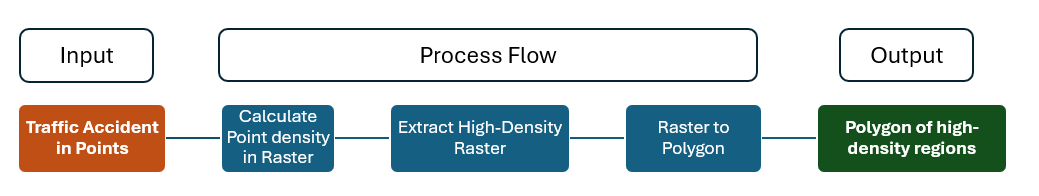
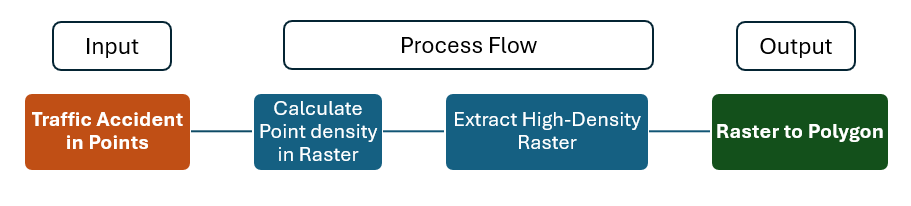

## Step-by-Step Guide: Building a Custom Extract-High-Density Tool

### Open the IDLE Environment

 - Open python command prompt

 - Open the IDLE development environment for ArcGIS Pro
Type `idle`, then click enter

- Create a new file to display the script window
Select File  > new File

### Import Libraries and Set up Parameters

- Import the necessary libraries: arcpy for GIS processing, Spatial Analyst (for raster operations), and numpy for array calculations.

```
import arcpy
from arcpy.sa import *
import numpy as np
```

### Define the parameters
#### Input and Output

Uinsg [GetParameterAsText](https://pro.arcgis.com/en/pro-app/latest/arcpy/functions/getparameterastext.htm) to access the input data and export data

- input_shapefile: Point Shapefile.
- output_polygons: Polygon Shapefile.

```
input_shapefile = arcpy.GetParameterAsText(0)  # Input wildlife sightings point shapefile
output_polygons = arcpy.GetParameterAsText(1)  # Output shapefile for the hotspots
```

### Point Density
[Point density](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/point-density.htm) tool generate a magnitude-per-unit area from point features taht consider the neighborhood cells

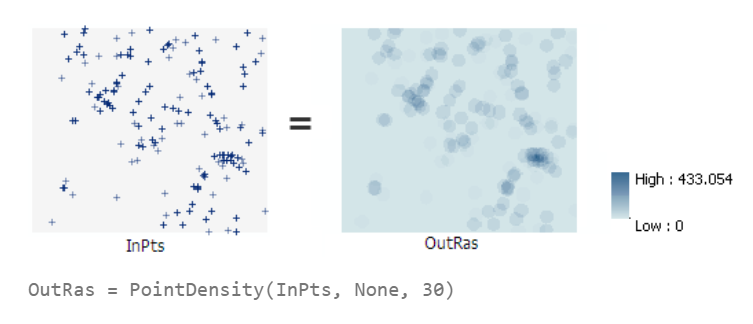

[Image source](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/point-density.htm)

We want the user to specify the cell size then we need to create a parameter for the cell size
- cell_size: Size of each cell for density calculation.

```
cell_size = arcpy.GetParameterAsText(2)  # Cell size
```

### Extract High-Density Regions

For the example below, each value represent the point's density at that cell. 

Cells highlighted in yellow indicate areas with higher point densities, ranking in the top 30%. 

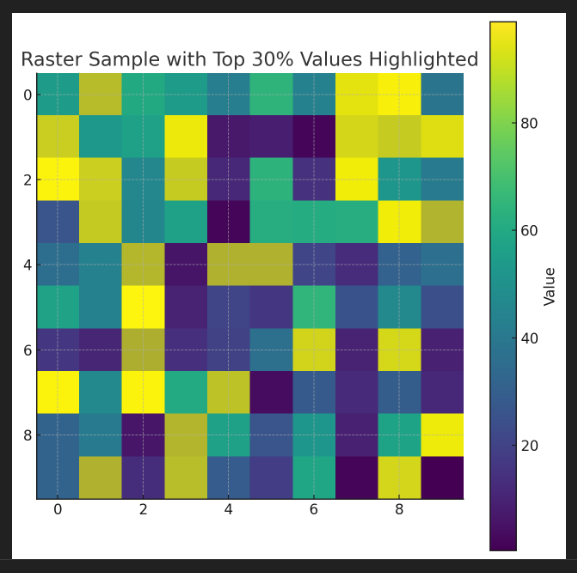  

For the tool, the user need to specify the percentile to extract cells with higher point densities.

- top_percentage: Percentage threshold to identify top-density areas (e.g., 10% for top 10%).

```
top_percentage = arcpy.GetParameterAsText(3)
```


#### Calculate Point Density

[Point Density Python](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/point-density.htm)

1. We need to define the input shapefile, population field, and cell size. 

```
density_raster = PointDensity(in_point_features = input_shapefile, population_field = None, cell_size=cell_size)
```

2. Save the density_raster to temporary space without creating a file on the disk 
3. 
'in_memory' is a workspace in ArcGIS that allows temporary storage of data directly in system memory (RAM) other than saving it to disk. 
```
density_raster.save("in_memory/density_raster")
```

### Find the threshold value based on the percentile

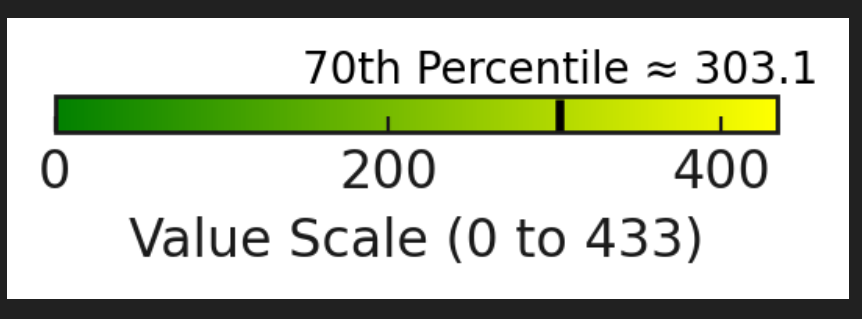

- Convert the raster to array
  
```
percentile_value = 100 - float(top_percentage)  # e.g., for top 30%, we need the 70th percentile
density_values = arcpy.RasterToNumPyArray(density_raster, nodata_to_value=-9999)
density_values = density_values[density_values > 0]  # Exclude no-data and zero density cells
```

- If the output density value is 0 for all the cell, then output the error message. If not, then get the threshold value 

[AddError](https://pro.arcgis.com/en/pro-app/latest/arcpy/functions/adderror.htm) tool can add an error message to the Python toolbox or a script tool. 

```
if density_values.size == 0:
    arcpy.AddError("Density raster contains no valid values. Check your inputs or adjust cell size and search radius.")
    raise ValueError("Empty density raster array")
else:
    threshold_value = np.percentile(density_values, percentile_value)
```

### Extract cells with higher point densities

[Con in Arcpy](https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-analyst/con-.htm)

```
high_density_raster = Con(in_conditional_raster = density_raster > threshold_value, in_true_raster_or_constant = 1)
```

### Convert the Raster to Polygon

Converts a raster data to polygon features. 

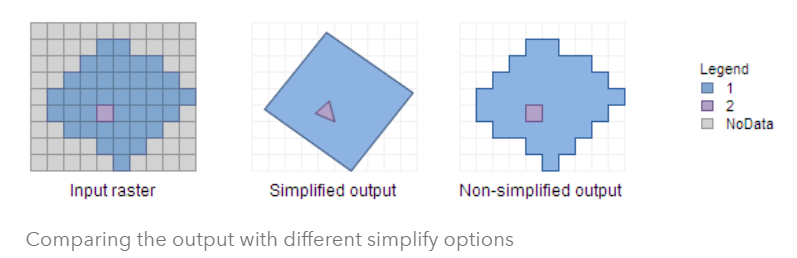

```
arcpy.RasterToPolygon_conversion(in_raster = high_density_raster, out_polygon_features = output_polygons, simplify = "NO_SIMPLIFY", raster_field = "VALUE")
```

### Remove the temporal file

[Delete data in temporal memory](https://desktop.arcgis.com/en/arcmap/latest/tools/data-management-toolbox/delete.htm)

[Add Message](https://pro.arcgis.com/en/pro-app/latest/arcpy/functions/addmessage.htm)

```
arcpy.Delete_management("in_memory/density_raster")
arcpy.AddMessage(f"Hotspot polygons created successfully using the top {top_percentage}% threshold (density threshold = {threshold_value}).")
```

## Create custom tool in ArcGIS Pro
### General
In the Catalog pane, expand the Toolboxes section, there is a toolbox aclled week11.atbx. 

Right click week11.atba, and select New > Script

On the general tab, enter the following information: Name, Label, and Toolbox

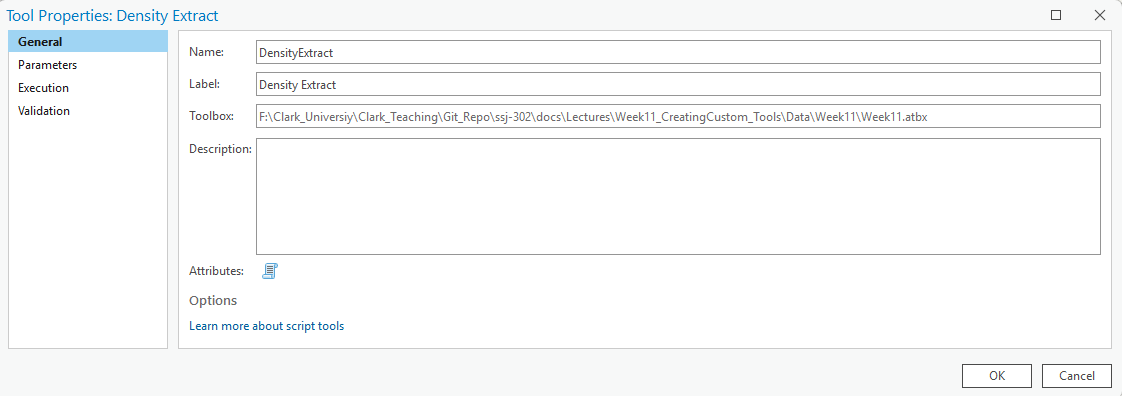

### Parameter

Each of the parameter is correspond to an parameter in the script. 

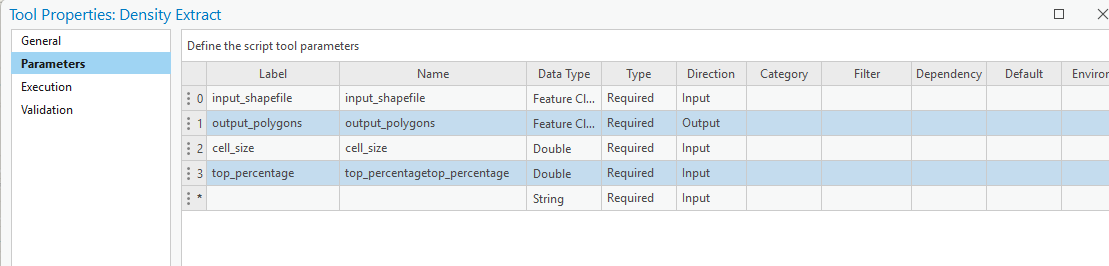

### Execution

Click the Execution tab, the window first show some boilerplate code. You can write the script using this interface or you can write the code using an external development environment like IDLE, PyCharm or VS Code. 

Then import the code to the script tool. 

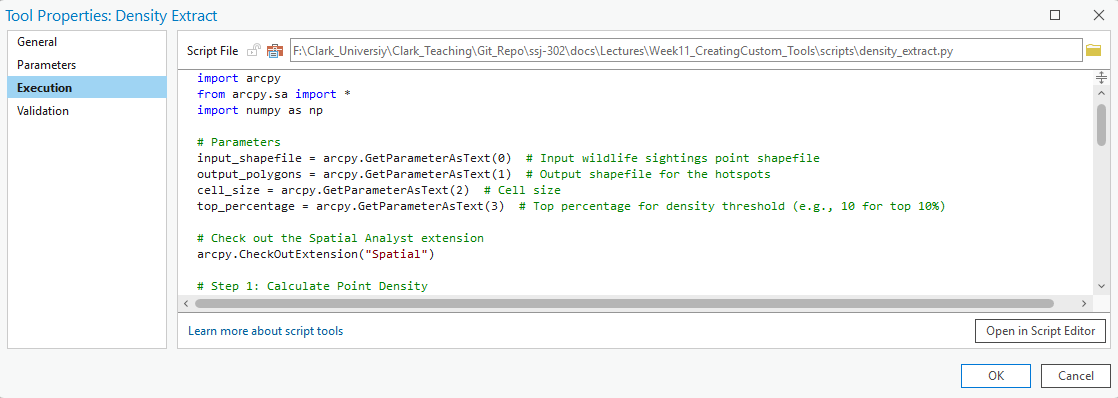

## Run the Script Tool

Double click the tool and display the interface for the custom script tool

Select traff_acc.shp as input shapefile

Set up the location of output polygon

Set up the cell size as 100

Set up the top_percentage as 50

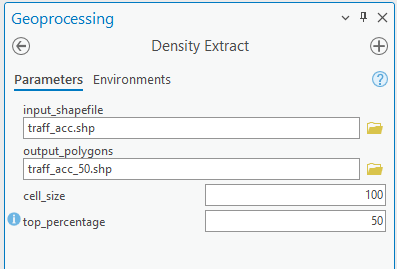

## Result

### Regions with higher point densities (Top 50%)

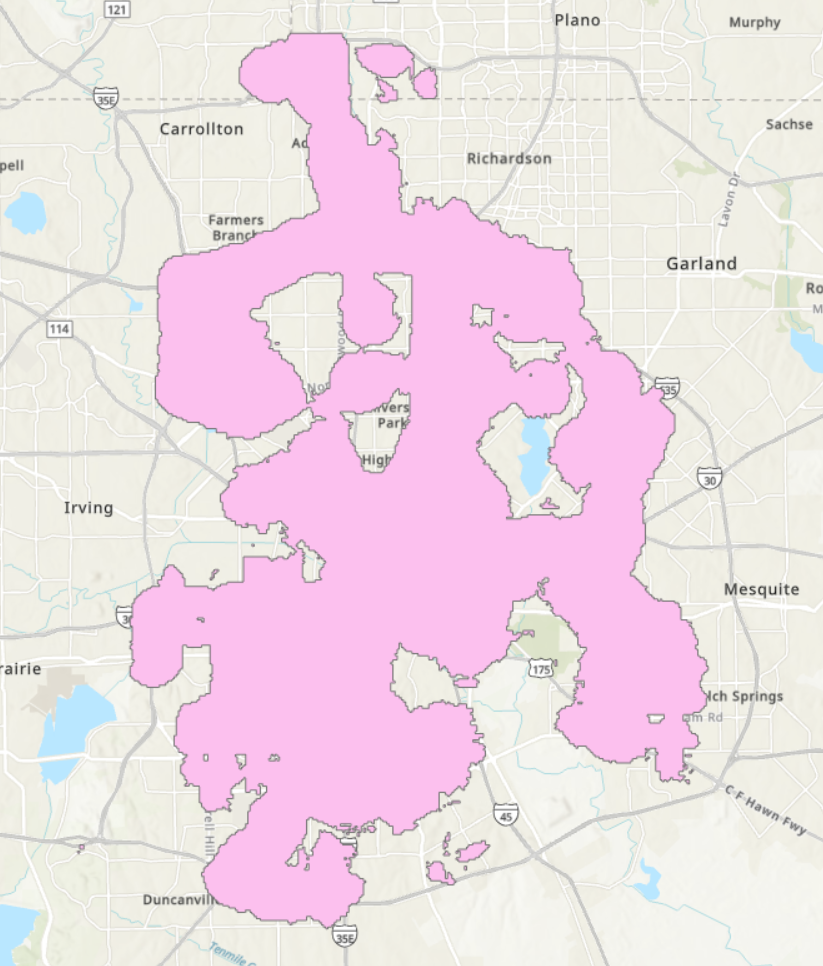

### Regions with lower point densities (Top 50% & 20%)

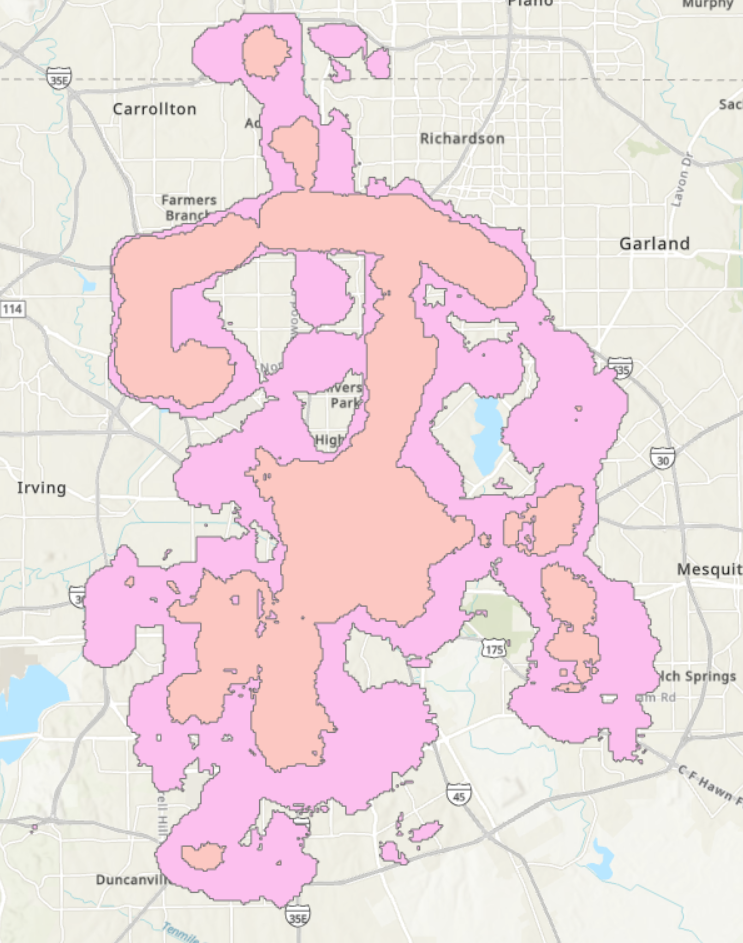